The implementations are based on Github [kekmodel's FixMatch-pytorch](https://github.com/kekmodel/FixMatch-pytorch)

In [1]:
import os
import logging
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

import models.wideresnet as models
from models.ema import ModelEMA
from utils import AverageMeter, accuracy
from dataset.randaugment import RandAugmentMC

**Parameters**

In [2]:
# TODO
class Config:
    CLASSES = ["art_sociology", "atlantic", "brendan_iribe_center", "denton", "elkton", \
                "ellicott", "esj", "farm_building", "hagerstown", "james_clark", \
                "laplata", "manufacture", "mckeldinlib", "oakland", "physics", \
                "prince_frederick", "reckord_armory", "recreation", "regents_drive", "yahentamitsi"]
    NUM_CLASSES = len(CLASSES)
    IMAGE_SIZE = 224
    
    DEVICE = torch.device("cuda", 0)
    NUM_WORKERS = 16 # {2, 4, 8, 16, ...} Depends on the system's CPU
    
    PATH = './photos'
    
    BATCH_SIZE = 2**4
    
    TOTAL_STEPS = 2**15 # number of total steps to run
    EVAL_STEPS = 2**10 # number of eval steps to run
    EPOCHS = math.ceil(TOTAL_STEPS / EVAL_STEPS)
    
    LR = 0.001
    WEIGHT_DECAY = 5e-4
    MOMENTUM = 0.99
    
    WARM_UP = 0 # warmup epochs (unlabeled data based)
    
    EMA_DECAY = 0.999 # EMA decay rate
    
    # Hyper-param for wideresnet
    WIDERESNET_DEPTH = 16
    WIDERESNET_WIDEN_FACTOR=2
    WIDERESNET_DROPOUT=1
    
    MU = 3 # coefficient of unlabeled batch size
    LAMBDA_U = 1 # coefficient of unlabeled loss
    
    THRESHOLD = 0.95 # pseudo label threshold
    T = 1 # pseudo label temperature

Define transforms

In [3]:
class TransformFixMatch(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=Config.IMAGE_SIZE,
                                  padding=int(Config.IMAGE_SIZE*0.125),
                                  padding_mode='reflect')])
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=Config.IMAGE_SIZE,
                                  padding=int(Config.IMAGE_SIZE*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

In [4]:
class UnlabeledTrainDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder + '/train_unlabeled'
        self.image_files = os.listdir(self.image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            weak_image, strong_image = self.transform(image)
            return weak_image, strong_image

        return image

In [5]:
class LabeledTrainDataset(Dataset):
    
    def __init__(self, image_folder, classes, transform=None):
        self.image_folder = image_folder + '/train_labeled'
        self.classes = classes
        self.transform = transform
        
        # Recursively collect all image paths from subdirectories
        self.image_paths = []
        for root, _, files in os.walk(self.image_folder):
            for file in files:
                if file.endswith((".jpg", ".jpeg", ".JPG")):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        label = None
        for i, cls in enumerate(self.classes):
            if cls in os.path.basename(img_path):
                label = i
                break

        if label is None:
            raise ValueError(f"Class label not found in file name: {img_path}")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [6]:
class TestDataset(Dataset):
    
    def __init__(self, image_folder, classes, transform=None):
        self.image_folder = image_folder + '/test'
        self.classes = classes
        self.transform = transform
        self.image_files = os.listdir(self.image_folder)

    def __len__(self):
        return len(self.image_files)
            
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        label = None
        for i, cls in enumerate(self.classes):
            if cls in os.path.basename(img_path):
                label = i
                break

        if label is None:
            raise ValueError(f"Class label not found in file name: {img_path}")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
def get_datasets(transform_labeled, transform_unlabeled):
    train_labeled = LabeledTrainDataset(image_folder=Config.PATH, classes=Config.CLASSES, transform=transform_labeled)
    train_unlabeled = UnlabeledTrainDataset(image_folder=Config.PATH, transform=transform_unlabeled)
    test = TestDataset(image_folder=Config.PATH, classes=Config.CLASSES, transform=transform_labeled)
    
    return train_labeled, train_unlabeled, test

In [8]:
# Define mean and std for normalization
mean = [0.3746, 0.3788, 0.3770]
std = [0.1741, 0.1764, 0.2034]

transform_labeled = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Use TransformFixMatch for unlabeled data
transform_unlabeled = TransformFixMatch(mean=mean, std=std)

Models

In [9]:
def get_resnet18(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, Config.NUM_CLASSES)
    return model

def get_wideresnet():
    return models.build_wideresnet(depth=Config.WIDERESNET_DEPTH,
                                    widen_factor=Config.WIDERESNET_WIDEN_FACTOR,
                                    dropout=Config.WIDERESNET_DROPOUT,
                                    num_classes=Config.NUM_CLASSES)

Load labeled train, unlabeled train, and test dataset

In [10]:
labeled_train_dataset, unlabeled_train_dataset, test_dataset = get_datasets(transform_labeled, transform_unlabeled)

Display some test photos

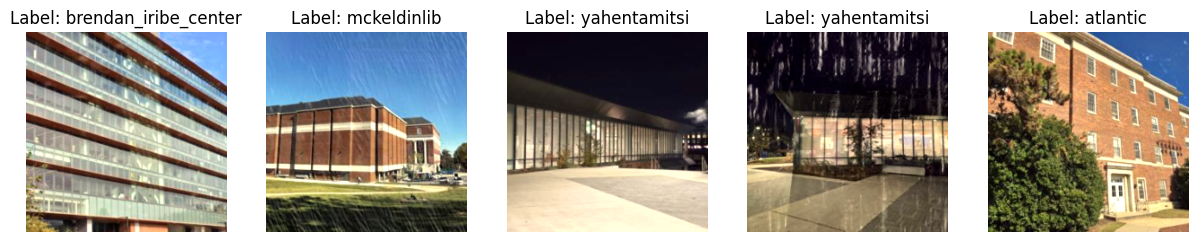

In [11]:
def show_images(dataset, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image, label = dataset[i]
        # Denormalize the image for visualization
        image = image.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        image = image.clamp(0, 1)
        
        axes[i].imshow(image.cpu().numpy())
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

# Display 5 images from the test dataset
show_images(test_dataset, 5)
plt.show()

In [12]:
labeled_trainloader = DataLoader(
    labeled_train_dataset,
    sampler=RandomSampler(labeled_train_dataset),
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    drop_last=True)

unlabeled_trainloader = DataLoader(
    unlabeled_train_dataset,
    sampler=RandomSampler(unlabeled_train_dataset),
    batch_size=Config.BATCH_SIZE*Config.MU,
    num_workers=Config.NUM_WORKERS,
    drop_last=True)

test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS)

In [13]:
def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)

In [14]:
def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

Load the existing model

In [15]:
def load_model(file_path, model, optimizer):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    print(f"Loaded model and optimizer from epoch {epoch}")
    return model, optimizer, epoch

Save the current model

In [16]:
def save_model(model, optimizer, epoch, file_path):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, file_path)
    print(f"Model saved to {file_path}")

Use either resnet18 or wide resnet and create the optimizer

In [17]:
# model = get_resnet18(True)
model = get_wideresnet()
model.to(Config.DEVICE)

no_decay = ['bias', 'bn']
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': Config.WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(grouped_parameters, lr=Config.LR, 
                        momentum=Config.MOMENTUM, nesterov=True) # use nesterov momentum

In [ ]:
# model, optimizer, _ = load_model('./fixmatch03.ckpt', model, optimizer)

Loaded model and optimizer from epoch 32


/tmp/ipykernel_1257/3530679069.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


In [19]:
scheduler = get_cosine_schedule_with_warmup(
            optimizer, Config.WARM_UP, Config.TOTAL_STEPS)

ema_model = ModelEMA(Config.DEVICE, model, Config.EMA_DECAY)

In [20]:
logger = logging.getLogger(__name__)
best_acc = 0
start_epoch = 0

In [21]:
def test(test_loader, model):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    test_loader = tqdm(test_loader, disable=False)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            data_time.update(time.time() - end)
            model.eval()

            inputs = inputs.to(Config.DEVICE)
            targets = targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.shape[0])
            top1.update(prec1.item(), inputs.shape[0])
            top5.update(prec5.item(), inputs.shape[0])
            batch_time.update(time.time() - end)
            end = time.time()

            test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. top1: {top1:.2f}. top5: {top5:.2f}. ".format(
                batch=batch_idx + 1,
                iter=len(test_loader),
                data=data_time.avg,
                bt=batch_time.avg,
                loss=losses.avg,
                top1=top1.avg,
                top5=top5.avg,
            ))

        test_loader.close()

    logger.info("top-1 acc: {:.2f}".format(top1.avg))
    logger.info("top-5 acc: {:.2f}".format(top5.avg))
    return losses.avg, top1.avg

In [22]:
def train():

    global best_acc
    test_accs = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)

    model.train()
    
    for epoch in range(start_epoch, Config.EPOCHS):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()
        
        # progress bar
        p_bar = tqdm(range(Config.EVAL_STEPS))
        
        for batch_idx in range(Config.EVAL_STEPS):
            
            try:
                # inputs_x, targets_x = labeled_iter.next()
                # error occurs ↓
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                # inputs_x, targets_x = labeled_iter.next()
                # error occurs ↓
                inputs_x, targets_x = next(labeled_iter)

            try:
                # (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
                # error occurs ↓
                inputs_u_w, inputs_u_s = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                # (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
                # error occurs ↓
                inputs_u_w, inputs_u_s = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            
            inputs = interleave(
                torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*Config.MU+1).to(Config.DEVICE)
            targets_x = targets_x.to(Config.DEVICE)
            logits = model(inputs)
            logits = de_interleave(logits, 2*Config.MU+1)
            logits_x = logits[:batch_size]
            logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            del logits

            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach()/Config.T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(Config.THRESHOLD).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()
            loss = Lx + Config.LAMBDA_U * Lu
            loss.backward()

            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            ema_model.update(model)
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                epoch=epoch + 1,
                epochs=Config.EPOCHS,
                batch=batch_idx + 1,
                iter=Config.EVAL_STEPS,
                lr=scheduler.get_last_lr()[0],
                data=data_time.avg,
                bt=batch_time.avg,
                loss=losses.avg,
                loss_x=losses_x.avg,
                loss_u=losses_u.avg,
                mask=mask_probs.avg))
            p_bar.update()

        p_bar.close()

        test_model = ema_model.ema

        test_loss, test_acc = test(test_loader, test_model)

        best_acc = max(test_acc, best_acc)
        test_accs.append(test_acc)
        logger.info('Best top-1 acc: {:.2f}'.format(best_acc))
        logger.info('Mean top-1 acc: {:.2f}\n'.format(
                    np.mean(test_accs[-20:])))

In [ ]:
logger.info("***** Running training *****")
logger.info(f"  Task = {Config.NUM_CLASSES} Buildings Classifications")
logger.info(f"  Num Epochs = {Config.EPOCHS}")
logger.info(f"  Batch size = {Config.BATCH_SIZE}")
logger.info(f"  Total optimization steps = {Config.TOTAL_STEPS}")

model.zero_grad()
train()

save_model(model, optimizer, Config.EPOCHS, 'fixmatch.ckpt')

Train Epoch: 1/  32. Iter: 1024/1024. LR: 0.0100. Data: 2.194s. Batch: 2.721s. Loss: 1.2386. Loss_x: 0.7379. Loss_u: 0.5006. Mask: 0.10. : 100%|██████████| 1024/1024 [46:25<00:00,  2.72s/it]  
Test Iter:  122/ 122. Data: 0.007s. Batch: 0.024s. Loss: 2.9212. top1: 27.19. top5: 61.76. : 100%|██████████| 122/122 [00:02<00:00, 41.01it/s]
Train Epoch: 2/  32. Iter: 1024/1024. LR: 0.0100. Data: 2.218s. Batch: 2.753s. Loss: 1.1162. Loss_x: 0.6391. Loss_u: 0.4770. Mask: 0.09. : 100%|██████████| 1024/1024 [46:55<00:00,  2.75s/it] 
Test Iter:  122/ 122. Data: 0.007s. Batch: 0.022s. Loss: 2.5076. top1: 32.97. top5: 70.28. : 100%|██████████| 122/122 [00:02<00:00, 44.39it/s]
Train Epoch: 3/  32. Iter: 1024/1024. LR: 0.0099. Data: 2.164s. Batch: 2.656s. Loss: 1.1195. Loss_x: 0.6264. Loss_u: 0.4931. Mask: 0.10. : 100%|██████████| 1024/1024 [45:16<00:00,  2.65s/it] 
Test Iter:  122/ 122. Data: 0.007s. Batch: 0.023s. Loss: 2.4002. top1: 35.50. top5: 72.81. : 100%|██████████| 122/122 [00:02<00:00, 43.61

Model saved to fixmatch04.ckpt
